## Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading labraries

In [2]:
import numpy as np
import pandas as pd
import scipy.io
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras import Model,datasets
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten,
    Dropout, Reshape
)
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score

## SVM

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


In [ ]:
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(y)
print(class_counts)

# Calculate the total number of instances
total_instances = len(y)

# Calculate and print the percentage of each class
class_percentages = {cls: count / total_instances * 100 for cls, count in class_counts.items()}
for cls, percentage in class_percentages.items():
    print(f"Class '{cls}': {percentage:.1f}%")

Counter({'BRCA_LumA': 499, 'BRCA_LumB': 197, 'BRCA_Basal': 171, 'BRCA_Her2': 78, 'BRCA_Normal': 36})
Class 'BRCA_LumA': 50.9%
Class 'BRCA_Her2': 8.0%
Class 'BRCA_LumB': 20.1%
Class 'BRCA_Normal': 3.7%
Class 'BRCA_Basal': 17.4%


### Cross validation

In [ ]:
random_state = 38
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=random_state, stratify=y_enc)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []

for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])


    model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                        C = 3,
                                        probability=True,
                                        random_state=random_state
                                        ))
    clt = model.fit(X_train, y_train)
    y_pred = clt.predict(X_val)

    # Calculate metrics
    print(f"Accureacy: {accuracy_score(y_val, y_pred)}")
    accuracies.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred, average='weighted', zero_division=0))
    precisions.append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
    confusion_matrices.append(confusion_matrix(y_val, y_pred))
    kappas.append(cohen_kappa_score(y_val, y_pred))
    hamming_distances.append(hamming_loss(y_val, y_pred))

    fold_no = fold_no + 1

    # Break the loop after the first iteration to test the code
    #break

Training for fold1...
Accureacy: 0.8928571428571429
Training for fold2...
Accureacy: 0.8928571428571429
Training for fold3...
Accureacy: 0.8571428571428571
Training for fold4...
Accureacy: 0.8674698795180723
Training for fold5...
Accureacy: 0.891566265060241
Training for fold6...
Accureacy: 0.7831325301204819
Training for fold7...
Accureacy: 0.8554216867469879
Training for fold8...
Accureacy: 0.891566265060241
Training for fold9...
Accureacy: 0.7951807228915663
Training for fold10...
Accureacy: 0.8433734939759037


In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.8570567986230637
Average F1 Score: 0.8476096398354702
Average Precision: 0.8615254140497577
Average Recall: 0.8570567986230637


### Test accuracy

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [ ]:
start_time = time.time()
random_state = 38
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X_train, y_train)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])

X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])


model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                    C = 3,
                                    probability=True,
                                    random_state=random_state
                                    ))
clt = model.fit(X_train, y_train)

y_pred = clt.predict(X_test)
# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

KeyboardInterrupt: 

In [ ]:
# Calculate metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Precision: {precision(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy: 0.8629441624365483
F1 Score: 0.8543601196174606
Precision: 0.8543601196174606


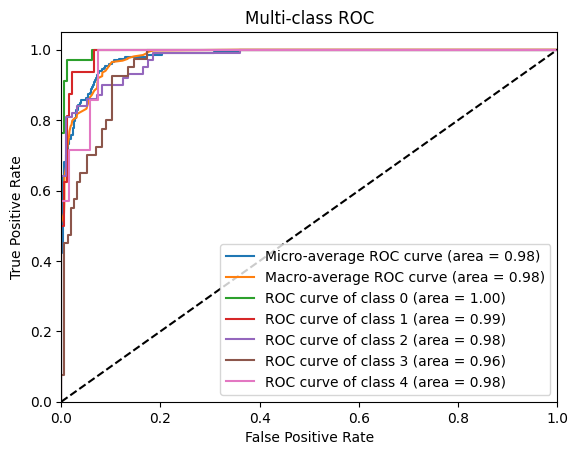

In [ ]:
# Predict probabilities instead of classes
y_prob = clt.predict_proba(X_test)

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is: {ratio}:")

  random_state = 38
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=random_state, stratify=y)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)


  model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                      C = 3,
                                      probability=True,
                                      random_state=random_state
                                      ))
  clt = model.fit(X_train, y_train)

  y_pred = clt.predict(X_test)

  # Calculate metrics
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # Get probability estimates
  y_pred_proba = clt.predict_proba(X_test)

  # Binarize the labels for AUC calculation
  y_test_binarized = label_binarize(y_test, classes=np.unique(y))

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
  print(f"AUC: {auc_score}")


  avg_acc.append(accuracy_score(y_test, y_pred))
  avg_f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is: 0.1:
Accuracy: 0.9090909090909091
F1 Score: 0.905449315158053
Precision: 0.9125002647015226
Total elapsed time: 358.0311088562012 seconds
AUC: 0.9862711660607986
The split ratio is: 0.15:
Accuracy: 0.8851351351351351
F1 Score: 0.8786860859146002
Precision: 0.890092545213027
Total elapsed time: 321.1007351875305 seconds
AUC: 0.9836116236795991
The split ratio is: 0.2:
Accuracy: 0.8527918781725888
F1 Score: 0.8420296332247071
Precision: 0.8552339141171628
Total elapsed time: 294.3557622432709 seconds
AUC: 0.97992888407333
The split ratio is: 0.25:
Accuracy: 0.8617886178861789
F1 Score: 0.851209961685352
Precision: 0.8656105858518371
Total elapsed time: 268.1964180469513 seconds
AUC: 0.9805631117784601
The split ratio is: 0.3:
Accuracy: 0.8711864406779661
F1 Score: 0.8583494194706758
Precision: 0.8774646618785296
Total elapsed time: 247.4403691291809 seconds
AUC: 0.9794105710372157


In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Accuracy: 0.8759985961925556
Average F1 Score: 0.8671448830906776
Average Precision: 0.8801803943524158
Average Computing time: 297.82487869262695
Average AUC: 0.9819570713258807


### Training 5 times for each ratio


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()
    print(f"Training seed {seed}...")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                        C = 3,
                                        probability=True,
                                        random_state=38
                                        ))
    clt = model.fit(X_train, y_train)

    y_pred = clt.predict(X_test)

    # Calculate metrics
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    #print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    # Get probability estimates
    y_pred_proba = clt.predict_proba(X_test)

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
    aupr = average_precision_score(y_test_binarized, y_pred_proba, average='weighted')
    #print(f"AUC: {auc_score}")


    avg_acc_s.append(accuracy_score(y_test, y_pred))
    avg_f1_s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8686868686868687
Avreage F1: 0.8601036655667155
Avreage precision: 0.8755761877095642
Avreage auc: 0.9839413453744854
Avreage aupr: 0.9483478517584001
Avreage time: 159.8505136013031
The split ratio is: 0.15:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8702702702702702
Avreage F1: 0.8616163532093347
Avreage precision: 0.8737525874944161
Avreage auc: 0.9831227468771202
Avreage aupr: 0.9427418425602934
Avreage time: 142.2492946624756
The split ratio is: 0.2:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8639593908629442
Avreage F1: 0.8543512959710805
Avreage precision: 0.8644807030585475
Avreage auc: 0.9822447136383922
Avreage aupr: 0.9396249280532638
Avreage time: 130.76607370376587
The split ratio is: 

In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.3,0.4,0.5,0.6,0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()
    print(f"Training seed {seed}...")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    model = OneVsRestClassifier(svm.SVC(kernel='rbf',
                                        C = 3,
                                        probability=True,
                                        random_state=38
                                        ))
    clt = model.fit(X_train, y_train)

    y_pred = clt.predict(X_test)

    # Calculate metrics
    #print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    #print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    # Get probability estimates
    y_pred_proba = clt.predict_proba(X_test)

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
    aupr = average_precision_score(y_test_binarized, y_pred_proba, average='weighted')
    #print(f"AUC: {auc_score}")


    avg_acc_s.append(accuracy_score(y_test, y_pred))
    avg_f1_s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8623728813559322
Avreage F1: 0.8521879019018858
Avreage precision: 0.863498037882264
Avreage auc: 0.9831958137230759
Avreage aupr: 0.9457184502850666
Avreage time: 137.97394933700562
The split ratio is: 0.4:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8549618320610687
Avreage F1: 0.8422823417325823
Avreage precision: 0.8564117334808989
Avreage auc: 0.9806709952655617
Avreage aupr: 0.9398519013403674
Avreage time: 103.13086013793945
The split ratio is: 0.5:
Training seed 3...
Training seed 8...
Training seed 19...
Training seed 66...
Training seed 38...
Avreage accuracy: 0.8480651731160895
Avreage F1: 0.8330385713228827
Avreage precision: 0.8505014046287924
Avreage auc: 0.9785869619891152
Avreage aupr: 0.9363476131542037
Avreage time: 87.38373966217041
The split ratio is: 0

### Feature selection

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# random_state = 38
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)

X_train, y_train = smote.fit_resample(X, y)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)

# # Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

clt = OneVsRestClassifier(SVC(kernel='linear', C=3, random_state=38))
clt.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=3, kernel='linear', random_state=38))

In [ ]:
import numpy as np

# Extract feature coefficients from each classifier
coefficients = np.array([estimator.coef_[0] for estimator in clt.estimators_])

# Aggregate coefficients - you can use different methods like mean, absolute mean, max, etc.
# Here we use the absolute mean to consider overall importance irrespective of the class
feature_importance = np.mean(np.abs(coefficients), axis=0)

# Get the indices of the top 20 features
top_20_indices = np.argsort(feature_importance)[-20:]

# Retrieve the names of the top 20 features
top_20_features = retained_features[top_20_indices]
print(top_20_features)

['388555' '80133' '284085' '256144' '404785' '27290' '79501' '23436'
 '136991' '448835' '139804' '163778' '5232' '153745' '3651' '286514'
 '23614' '1943' '168975' '171482']


## Deep insight

In [ ]:
!pip -q install git+https://github.com/changdali1207/pyDeepInsight.git#egg=pyDeepInsight
!pip install umap-learn
!pip install timm==0.9.12

from pyDeepInsight import ImageTransformer, CAMFeatureSelector
from pyDeepInsight.utils import Norm2Scaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Warnings
import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.1 MB/s eta 0:00:00


In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/BRCA_TCGA.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 20532)


### Cross validation

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=36, stratify=y_enc)
print(X_train_temp.shape)
print(X_test.shape)

random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []


for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_val_norm = mms.transform(X_val[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224,224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_val_img = it.transform(X_val_norm)

    # Set random seed for reproducibility
    random_seed = 38
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_val_tensor = torch.stack([preprocess(img) for img in  X_val_img]).float().to(device)
    y_val_tensor = torch.from_numpy(y_val).to(device)
    valset = TensorDataset(X_val_tensor, y_val_tensor)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-02,
        momentum=0.9,
    )

    net.train()
    for epoch in range(100):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    val_predicted = np.empty(0)
    val_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            val_predicted = np.append(val_predicted, pred)
            val_true = np.append(val_true, labels.cpu().detach().numpy())

    # Calculate metrics
    print(f"Accuracy: {accuracy_score(val_predicted, val_true) * 100 :.3f}")
    accuracies.append(accuracy_score(val_predicted, val_true))
    f1_scores.append(f1_score(val_predicted, val_true, average='weighted', zero_division=0))
    precisions.append(precision_score(val_predicted, val_true, average='weighted', zero_division=0))
    recalls.append(recall_score(val_predicted, val_true, average='weighted', zero_division=0))

    fold_no = fold_no + 1

(833, 19737)
(148, 19737)
Training for fold1...


KeyboardInterrupt: 

In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.8833907056798622
Average F1 Score: 0.8859015703217997
Average Precision: 0.9000430782833082
Average Recall: 0.8833907056798622


### Test accuracy

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [ ]:
Breast_cancer_no_na.head()

,0,1,2,3,4,5,6,7,8,9,...,20522,20523,20524,20525,20526,20527,20528,20529,20530,Subtype
0,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,0.0000,0.0,...,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460,BRCA_LumA
1,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,0.5438,0.0,...,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743,BRCA_Her2
2,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,0.0000,0.0,...,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519,BRCA_LumB
3,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,0.0000,0.0,...,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869,BRCA_LumA
4,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,0.0000,0.0,...,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702,BRCA_LumA


Elapsed time: 68.51899743080139 seconds


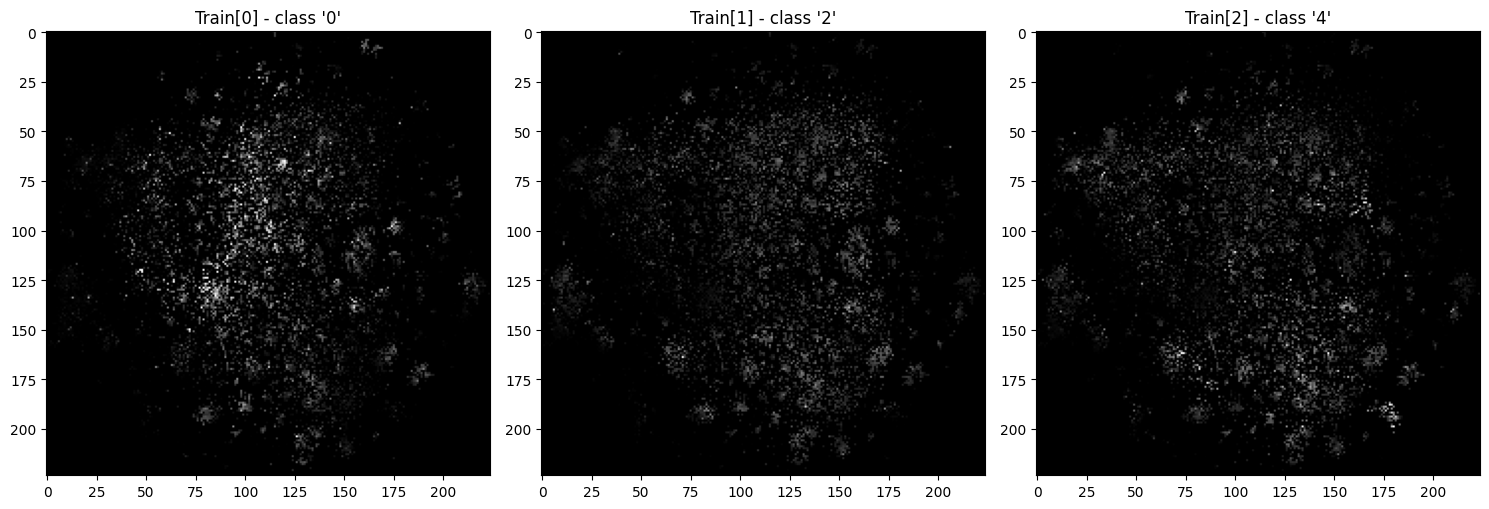

In [ ]:
# Start timing
start_time = time.time()
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)[var_filter]

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])

distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

it.fit(X_train_norm, y=y_train_enc, plot=False)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i],cmap='viridis')
    ax[i].title.set_text(f"Train[{i}] - class '{y_train_enc[i]}'")
plt.tight_layout()

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

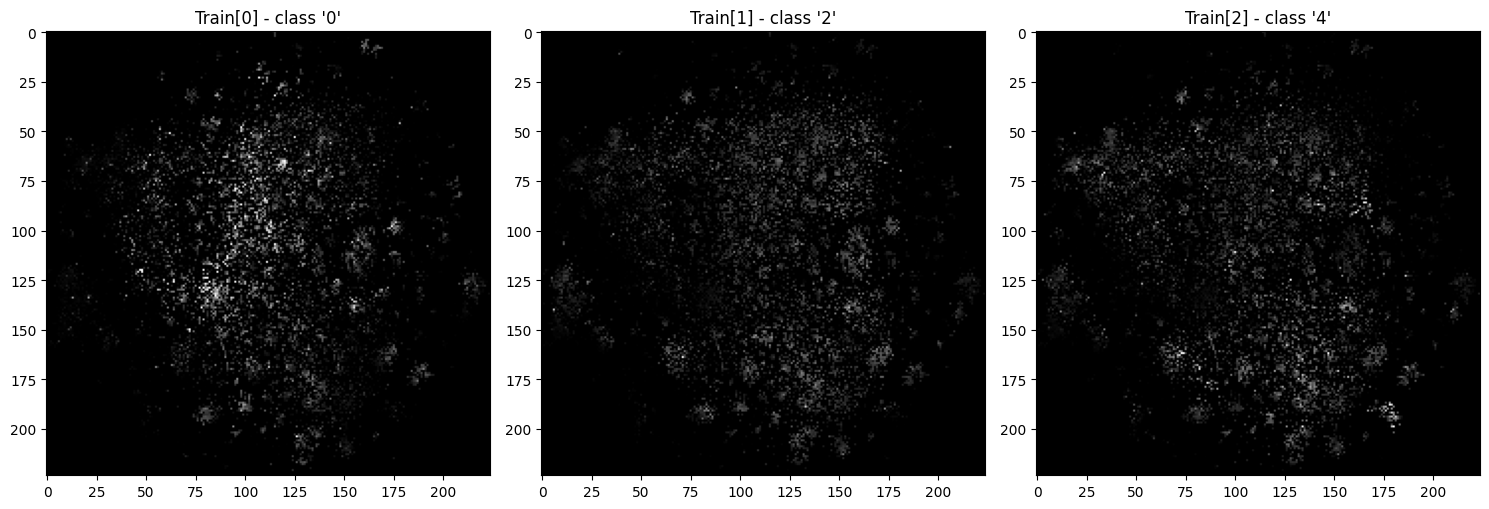

In [ ]:
image_copy = X_train_img
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    image_copy[i]
    image_copy = X_train_img[i]
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train_enc[i]}'")
plt.tight_layout()

In [ ]:
start_time = time.time()
# Set random seed for reproducibility
random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=16
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-03,
    momentum=0.9
)

net.train()
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #clear_output(wait=True)
        #display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print epoch statistics
    if not (epoch % 10):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# End timing
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time_2 = end_time - start_time
print(f"Total elapsed time: {elapsed_time_1 + elapsed_time_2} seconds")

[0] loss: 0.69677625
[10] loss: 0.00156570
[20] loss: 0.00063100
[30] loss: 0.00067574
[40] loss: 0.00027007
[50] loss: 0.00033908
[60] loss: 0.00023183
[70] loss: 0.00014365
[80] loss: 0.00010069
[90] loss: 0.00008317
[99] loss: 0.00015808
The test accuracy was 0.853
The F1 score was 0.855
The Precession was 0.868
Total elapsed time: 555.3204665184021 seconds


In [ ]:
device = torch.device('cuda')
net = timm.create_model('resnet26d', pretrained=True, num_classes=5).to(device)
net = net.to(device)

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

In [ ]:
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()

  print(f"The split ratio is: {ratio}:")

  X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=38, stratify=y_enc)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  mms = MinMaxScaler()
  X_train_norm = mms.fit_transform(X_train[:, var_filter])
  X_test_norm = mms.transform(X_test[:, var_filter])

  distance_metric = 'cosine'
  reducer = TSNE(
      n_components=2,
      metric=distance_metric,
      init='random',
      learning_rate='auto',
      n_jobs=-1
  )

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  pixel_size = (224,224)
  it = ImageTransformer(
      feature_extractor=reducer,
      pixels=pixel_size)

  it.fit(X_train_norm, y=y_train_enc, plot=False)
  X_train_img = it.transform(X_train_norm)
  X_test_img = it.transform(X_test_norm)

  # Set random seed for reproducibility
  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  # Ensure deterministic behavior in PyTorch
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  device = torch.device('cuda')
  net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
  net = net.to(device)

  batch_size=16
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
  ])

  X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
  y_train_tensor = torch.from_numpy(y_train_enc).to(device)
  trainset = TensorDataset(X_train_tensor, y_train_tensor)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
  y_test_tensor = torch.from_numpy(y_test_enc).to(device)
  testset = TensorDataset(X_test_tensor, y_test_tensor)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
      net.parameters(),
      lr=1e-03,
      momentum=0.9
  )

  net.train()
  for epoch in range(100):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(trainloader):
          #clear_output(wait=True)
          #display(f"Epoch {epoch:03d}, batch {i:03d}")
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          # print epoch statistics
      if not (epoch % 10):
          print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
  print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

  test_predicted = np.empty(0)
  test_true = np.empty(0)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
          test_predicted = np.append(test_predicted, pred)
          test_true = np.append(test_true, labels.cpu().detach().numpy())
  print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
  print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
  print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # AUC
  y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

  test_probabilities = np.empty((0, num_classes))
  test_true_auc = np.empty((0, num_classes))

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          outputs = net(inputs)
          probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
          test_probabilities = np.vstack([test_probabilities, probabilities])
          test_true_auc = np.vstack([test_true_auc, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

  # Calculate Micro-Average AUC
  micro_average_auc = roc_auc_score(test_true_auc.ravel(), test_probabilities.ravel(), average='micro')
  print(f"The average AUC is: {micro_average_auc:.3f}")

  avg_acc.append(accuracy_score(test_predicted, test_true))
  avg_f1.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_pre.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(micro_average_auc)

In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

In [ ]:
# Assuming your classes are encoded from 0 to num_classes-1
y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

test_probabilities = np.empty((0, num_classes))
test_true = np.empty((0, num_classes))

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        outputs = net(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        test_probabilities = np.vstack([test_probabilities, probabilities])
        test_true = np.vstack([test_true, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

# Calculate Micro-Average AUC
micro_average_auc = roc_auc_score(test_true.ravel(), test_probabilities.ravel(), average='micro')

print(f"Micro-Average AUC: {micro_average_auc:.3f}")

Micro-Average AUC: 0.977


In [ ]:
# Assuming your classes are encoded from 0 to num_classes-1
y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

test_probabilities = np.empty((0, num_classes))
test_true = np.empty((0, num_classes))

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        outputs = net(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        test_probabilities = np.vstack([test_probabilities, probabilities])
        test_true = np.vstack([test_true, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

# Calculate ROC AUC for each class
roc_auc = dict()
for i in range(num_classes):
    roc_auc[i] = roc_auc_score(test_true[:, i], test_probabilities[:, i])

# Print AUC values
for i in range(num_classes):
    print(f"Class {i} AUC: {roc_auc[i]:.3f}")

Class 0 AUC: 0.998
Class 1 AUC: 0.969
Class 2 AUC: 0.965
Class 3 AUC: 0.960
Class 4 AUC: 0.870


In [ ]:
# Plot ROC curves
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_true[:, i], test_probabilities[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

### Training 5 times for each ratio


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
#[4455, 5310, 222, 521, 4459]
#[66, 1989, 38, 3, 8]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    #smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    #X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_test_norm = mms.transform(X_test[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224,224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train_enc, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_test_img = it.transform(X_test_norm)

    # Set random seed for reproducibility
    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train_enc).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
    y_test_tensor = torch.from_numpy(y_test_enc).to(device)
    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-03,
        momentum=0.9
    )

    net.train()
    for epoch in range(100):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    test_predicted = np.empty(0)
    test_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            test_predicted = np.append(test_predicted, pred)
            test_true = np.append(test_true, labels.cpu().detach().numpy())
    # print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
    # print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
    # print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    # print(f"Total elapsed time: {elapsed_time} seconds")

    # AUC
    y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

    test_probabilities = np.empty((0, num_classes))
    test_true_auc = np.empty((0, num_classes))

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = net(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            test_probabilities = np.vstack([test_probabilities, probabilities])
            test_true_auc = np.vstack([test_true_auc, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

    # Calculate Micro-Average AUC
    micro_average_auc = roc_auc_score(test_true_auc.ravel(), test_probabilities.ravel(), average='micro')
    aupr = average_precision_score(test_true_auc.ravel(), test_probabilities.ravel(), average="weighted")
    # print(f"The average AUC is: {micro_average_auc:.3f}")

    avg_acc_s.append(accuracy_score(test_predicted, test_true))
    avg_f1_s.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(micro_average_auc)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))
  avg_aupr.append(np.mean(avg_aupr_s))

The split ratio is: 0.1:
Training seed 3:
[0] loss: 1.10254970
[10] loss: 0.00753308
[20] loss: 0.03858496
[30] loss: 0.00327075
[40] loss: 0.09657143
[50] loss: 0.00068187
[60] loss: 0.00270354
[70] loss: 0.00435763
[80] loss: 0.00143828
[90] loss: 0.00314720
[99] loss: 0.01779402
Training seed 8:
[0] loss: 1.12516666
[10] loss: 0.07909576
[20] loss: 0.03047156
[30] loss: 0.00540418
[40] loss: 0.00698947
[50] loss: 0.01041286
[60] loss: 0.01758337
[70] loss: 0.03132783
[80] loss: 0.00727412
[90] loss: 0.00032430
[99] loss: 0.00489260
Training seed 19:
[0] loss: 1.13464282
[10] loss: 0.02869988
[20] loss: 0.01073211
[30] loss: 0.00245700
[40] loss: 0.00732955
[50] loss: 0.00110416
[60] loss: 0.00106326
[70] loss: 0.00659370
[80] loss: 0.00050202
[90] loss: 0.00116831
[99] loss: 0.00095566
Training seed 66:
[0] loss: 1.11261829
[10] loss: 0.04467436
[20] loss: 0.03517276
[30] loss: 0.00170347
[40] loss: 0.00097347
[50] loss: 0.00028551
[60] loss: 0.00026427
[70] loss: 0.03577373
[80] lo

In [ ]:
np.mean(avg_acc)

0.8639239108779989

### Examining the performance of DeepInsight by progressively decreasing the ratio.

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train[:, var_filter])
    X_test_norm = mms.transform(X_test[:, var_filter])

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        n_jobs=-1
    )

    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    pixel_size = (224,224)
    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)

    it.fit(X_train_norm, y=y_train_enc, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_test_img = it.transform(X_test_norm)

    # Set random seed for reproducibility
    random_seed = 36
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device('cuda')
    net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
    net = net.to(device)

    batch_size=16
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
    ])

    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train_enc).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
    y_test_tensor = torch.from_numpy(y_test_enc).to(device)
    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=1e-03,
        momentum=0.9
    )

    net.train()
    for epoch in range(100):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print epoch statistics
        if not (epoch % 10):
            print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
    print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

    test_predicted = np.empty(0)
    test_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            test_predicted = np.append(test_predicted, pred)
            test_true = np.append(test_true, labels.cpu().detach().numpy())
    # print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
    # print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
    # print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    # print(f"Total elapsed time: {elapsed_time} seconds")

    # AUC
    y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

    test_probabilities = np.empty((0, num_classes))
    test_true_auc = np.empty((0, num_classes))

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = net(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            test_probabilities = np.vstack([test_probabilities, probabilities])
            test_true_auc = np.vstack([test_true_auc, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

    # Calculate Micro-Average AUC
    micro_average_auc = roc_auc_score(test_true_auc.ravel(), test_probabilities.ravel(), average='micro')
    aupr = average_precision_score(test_true_auc.ravel(), test_probabilities.ravel(), average="weighted")
    # print(f"The average AUC is: {micro_average_auc:.3f}")

    avg_acc_s.append(accuracy_score(test_predicted, test_true))
    avg_f1_s.append(f1_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(test_predicted, test_true, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(micro_average_auc)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))
  avg_aupr.append(np.mean(avg_aupr_s))

The split ratio is: 0.4:
Training seed 3:


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.84856596
[10] loss: 0.00388267
[20] loss: 0.00467173
[30] loss: 0.00071846
[40] loss: 0.00058471
[50] loss: 0.00054606
[60] loss: 0.00032543
[70] loss: 0.00016802
[80] loss: 0.00009522
[90] loss: 0.00009002
[99] loss: 0.00007486
Training seed 8:
[0] loss: 0.84321526
[10] loss: 0.00216855
[20] loss: 0.00091537
[30] loss: 0.00044303
[40] loss: 0.00071707
[50] loss: 0.00032607
[60] loss: 0.00022271
[70] loss: 0.00043020
[80] loss: 0.00017246
[90] loss: 0.00013074
[99] loss: 0.00012251
Training seed 19:
[0] loss: 0.83586100
[10] loss: 0.00174146
[20] loss: 0.00240686
[30] loss: 0.00058416
[40] loss: 0.00047211
[50] loss: 0.00438073
[60] loss: 0.00080825
[70] loss: 0.00028909
[80] loss: 0.00025828
[90] loss: 0.00013191
[99] loss: 0.00015057
Training seed 66:
[0] loss: 0.83539025
[10] loss: 0.00235365
[20] loss: 0.00090717
[30] loss: 0.00057904
[40] loss: 0.00047323
[50] loss: 0.00032336
[60] loss: 0.00023521
[70] loss: 0.00021637
[80] loss: 0.00020019
[90] loss: 0.00016561
[99] 

### Examing the performance of DeepInsight of different image resolutions

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

image_resolution = [50, 120, 180, 224, 250, 280, 320]
for res in image_resolution:
  # Start timing
  start_time = time.time()

  print(f"The Resolustion is: {res}:")

  X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train_enc = smote.fit_resample(X_train, y_train_enc)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  mms = MinMaxScaler()
  X_train_norm = mms.fit_transform(X_train[:, var_filter])
  X_test_norm = mms.transform(X_test[:, var_filter])

  distance_metric = 'cosine'
  reducer = TSNE(
      n_components=2,
      metric=distance_metric,
      init='random',
      learning_rate='auto',
      n_jobs=-1
  )

  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  pixel_size = (res,res)
  it = ImageTransformer(
      feature_extractor=reducer,
      pixels=pixel_size)

  it.fit(X_train_norm, y=y_train_enc, plot=False)
  X_train_img = it.transform(X_train_norm)
  X_test_img = it.transform(X_test_norm)

  # Set random seed for reproducibility
  random_seed = 36
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)

  # Ensure deterministic behavior in PyTorch
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  device = torch.device('cuda')
  net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
  net = net.to(device)

  batch_size=16
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
  ])

  X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
  y_train_tensor = torch.from_numpy(y_train_enc).to(device)
  trainset = TensorDataset(X_train_tensor, y_train_tensor)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
  y_test_tensor = torch.from_numpy(y_test_enc).to(device)
  testset = TensorDataset(X_test_tensor, y_test_tensor)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(
      net.parameters(),
      lr=1e-03,
      momentum=0.9
  )

  net.train()
  for epoch in range(100):
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(trainloader):
          #clear_output(wait=True)
          #display(f"Epoch {epoch:03d}, batch {i:03d}")
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          # print epoch statistics
      if not (epoch % 10):
          print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
  print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

  test_predicted = np.empty(0)
  test_true = np.empty(0)

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
          test_predicted = np.append(test_predicted, pred)
          test_true = np.append(test_true, labels.cpu().detach().numpy())
  print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
  print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
  print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # AUC
  y_test_binarized = label_binarize(y_test_enc, classes=[*range(num_classes)])

  test_probabilities = np.empty((0, num_classes))
  test_true_auc = np.empty((0, num_classes))

  net.eval()
  with torch.no_grad():
      for i, (inputs, labels) in enumerate(testloader):
          outputs = net(inputs)
          probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
          test_probabilities = np.vstack([test_probabilities, probabilities])
          test_true_auc = np.vstack([test_true_auc, y_test_binarized[i * batch_size: i * batch_size + len(labels)]])

  # Calculate Micro-Average AUC
  micro_average_auc = roc_auc_score(test_true_auc.ravel(), test_probabilities.ravel(), average='micro')
  print(f"The average AUC is: {micro_average_auc:.3f}")

The Resolustion is: 50:


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

[0] loss: 0.64766083
[10] loss: 0.01045556
[20] loss: 0.00086700
[30] loss: 0.00497265
[40] loss: 0.00021288
[50] loss: 0.00041457
[60] loss: 0.00010560
[70] loss: 0.00007277
[80] loss: 0.00004220
[90] loss: 0.00003864
[99] loss: 0.00085887
The test accuracy was 0.817
The F1 score was 0.824
The Precession was 0.839
Total elapsed time: 240.91365337371826 seconds
The average AUC is: 0.977
The Resolustion is: 120:
[0] loss: 0.61190447
[10] loss: 0.00981462
[20] loss: 0.00066823
[30] loss: 0.00049684
[40] loss: 0.00091260
[50] loss: 0.00031108
[60] loss: 0.00014627
[70] loss: 0.00008681
[80] loss: 0.00011580
[90] loss: 0.00006162
[99] loss: 0.00130194
The test accuracy was 0.868
The F1 score was 0.874
The Precession was 0.888
Total elapsed time: 228.5422842502594 seconds
The average AUC is: 0.980
The Resolustion is: 180:
[0] loss: 0.64519360
[10] loss: 0.00167605
[20] loss: 0.00940072
[30] loss: 0.00153184
[40] loss: 0.00051238
[50] loss: 0.00057786
[60] loss: 0.00022653
[70] loss: 0.00012

### Feature selection

In [ ]:
# Start timing
start_time = time.time()
# X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
# X_train, y_train_enc = smote.fit_resample(X, y_enc)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
var_filter = X.var(0) >= np.percentile(X.var(0), 30., method='nearest')
retained_features = np.array(genes)[var_filter]

mms = MinMaxScaler()
# X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_train_norm = mms.fit_transform(X[:, var_filter])
# X_test_norm = mms.transform(X_test[:, var_filter])

distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

# it.fit(X_train_norm, y=y_train_enc, plot=False)
it.fit(X_train_norm, y=y_enc, plot=False)
X_train_img = it.transform(X_train_norm)
# X_test_img = it.transform(X_test_norm)

start_time = time.time()
# Set random seed for reproducibility
random_seed = 36
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=16
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
# y_train_tensor = torch.from_numpy(y_train_enc).to(device)
y_train_tensor = torch.from_numpy(y_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
# y_test_tensor = torch.from_numpy(y_test_enc).to(device)
# testset = TensorDataset(X_test_tensor, y_test_tensor)
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
# y_test_tensor = torch.from_numpy(y_test_enc).to(device)
# testset = TensorDataset(X_test_tensor, y_test_tensor)
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-03,
    momentum=0.9
)

net.train()
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        #clear_output(wait=True)
        #display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print epoch statistics
    if not (epoch % 10):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.8f}')

# test_predicted = np.empty(0)
# test_true = np.empty(0)

# net.eval()
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(testloader):
#         pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
#         test_predicted = np.append(test_predicted, pred)
#         test_true = np.append(test_true, labels.cpu().detach().numpy())
# print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")
# print(f"The F1 score was {f1_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# print(f"The Precession was {precision_score(test_predicted, test_true, average='weighted', zero_division=0):.3f}")
# # End timing
# end_time = time.time()
# # Calculate and print the elapsed time
# elapsed_time_2 = end_time - start_time
# print(f"Total elapsed time: {elapsed_time_1 + elapsed_time_2} seconds")

[0] loss: 1.10489656
[10] loss: 0.03086698
[20] loss: 0.00387322
[30] loss: 0.00100667
[40] loss: 0.00078844
[50] loss: 0.00340295
[60] loss: 0.01079742
[70] loss: 0.01001486
[80] loss: 0.00143984
[90] loss: 0.00048307
[99] loss: 0.00044146


In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=32, flatten_method=fl_method)
aggregated_cam = camfs.calculate_aggregated_activations(X_train_tensor, y_train_tensor, batch_size=32)

In [ ]:
fs_threshold_agg = 0.4637
fs_threshold_cls = 0.7
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold_cls)
top_features = camfs.select_top_features(aggregated_cam, top_n=20, threshold=fs_threshold_agg)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        #row = cat // 4
        col = cat % 5
        # print(col)
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[col].imshow(visualization)
        axs[col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        #axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[col].axis('off')
    return fig, axs

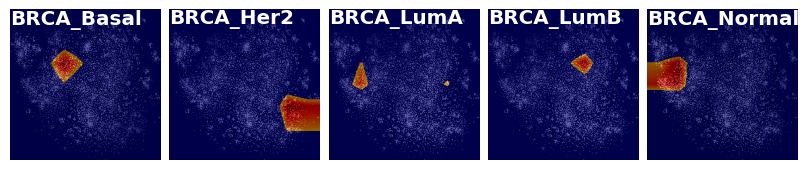

In [ ]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold_cls)

In [ ]:
feature_names = retained_features[top_features]
print(feature_names)
print(len(feature_names))

['340069' '29798' '462' '376497' '10014' '79089' '353219' '84336' '27175'
 '23761' '8534' '64748' '9545' '90933' '51149' '25759' '374882' '56654'
 '126075' '100129534' '113177']
21


In [ ]:
rows = []
for cat, idx in feat_idx.items():
    feature_names = retained_features[idx]
    row = {"Category": cat, "Features Selected": ", ".join(feature_names)}
    rows.append(row)
df = pd.DataFrame(rows)

In [ ]:
df

,Category,Features Selected
0,0,"6694, 83851, 8701, 221833, 442388, 389812, 107..."
1,1,"26156, 124808, 9343, 4836, 10197, 23204, 51283..."
2,2,"440822, 9951, 200150, 7044, 130497, 28965, 685..."
3,3,"3700, 91316, 25956, 275, 386593, 85378, 23015,..."
4,4,"6372, 83895, 2919, 2920, 2921, 150350, 722, 87..."


In [ ]:
for cat, idx in feat_idx.items():
    feature_names = retained_features[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[0:10])}...")

  148 features selected for BRCA_Basal: 1582, 1238, 1259, 344905, 389015, 415117, 130560, 3294, 7180, 219970...
  282 features selected for BRCA_Her2: 57403, 51012, 9217, 8480, 51497, 8813, 27304, 8675, 23394, 23054...
   16 features selected for BRCA_LumA: 53947, 2687, 113189, 58529, 142684, 72, 3316, 55679, 644538, 2621...
   44 features selected for BRCA_LumB: 653687, 1241, 56413, 730668, 387264, 440021, 339665, 143282, 55321, 4037...
  414 features selected for BRCA_Normal: 112937, 3773, 9542, 140803, 150572, 440822, 79937, 220382, 6285, 7018...


In [ ]:
feat = pd.DataFrame()
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    feat = pd.concat([feat, pd.DataFrame({'cancer':le_mapping[cat], 'gene':feature_names})])
fdf = feat.assign(selected=1).pivot(index='cancer', columns='gene', values="selected").fillna(0).astype(int)

pd.DataFrame(
    np.matmul(fdf.values,fdf.T.values),
    index=fdf.index.values,
    columns=fdf.index.values
)

,BRCA_Basal,BRCA_Her2,BRCA_LumA,BRCA_LumB,BRCA_Normal
BRCA_Basal,603,0,0,0,0
BRCA_Her2,0,769,0,0,0
BRCA_LumA,0,0,268,0,228
BRCA_LumB,0,0,0,282,0
BRCA_Normal,0,0,228,0,792


#### Trying to use SHAP

In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
net.eval()  # Set the model to evaluation mode

# Assuming X_train_tensor and y_train_tensor are already defined and preprocessed
# Select a subset for the background and test images
background = X_train_tensor[:100].to(device)  # Using a smaller background set
test_images = X_train_tensor[100:105].to(device)  # Selecting a few images for testing

# Identify the target layer for SHAP analysis in the 'net' model
# Adjust this based on the actual architecture of 'net'
target_layer = net.layer1

# Create a SHAP GradientExplainer using the specified layer
e = shap.GradientExplainer((net, target_layer), background)

# Compute SHAP values for the test images
shap_values = e.shap_values(test_images)

# Visualization code here (use y_train_tensor for labels if needed)

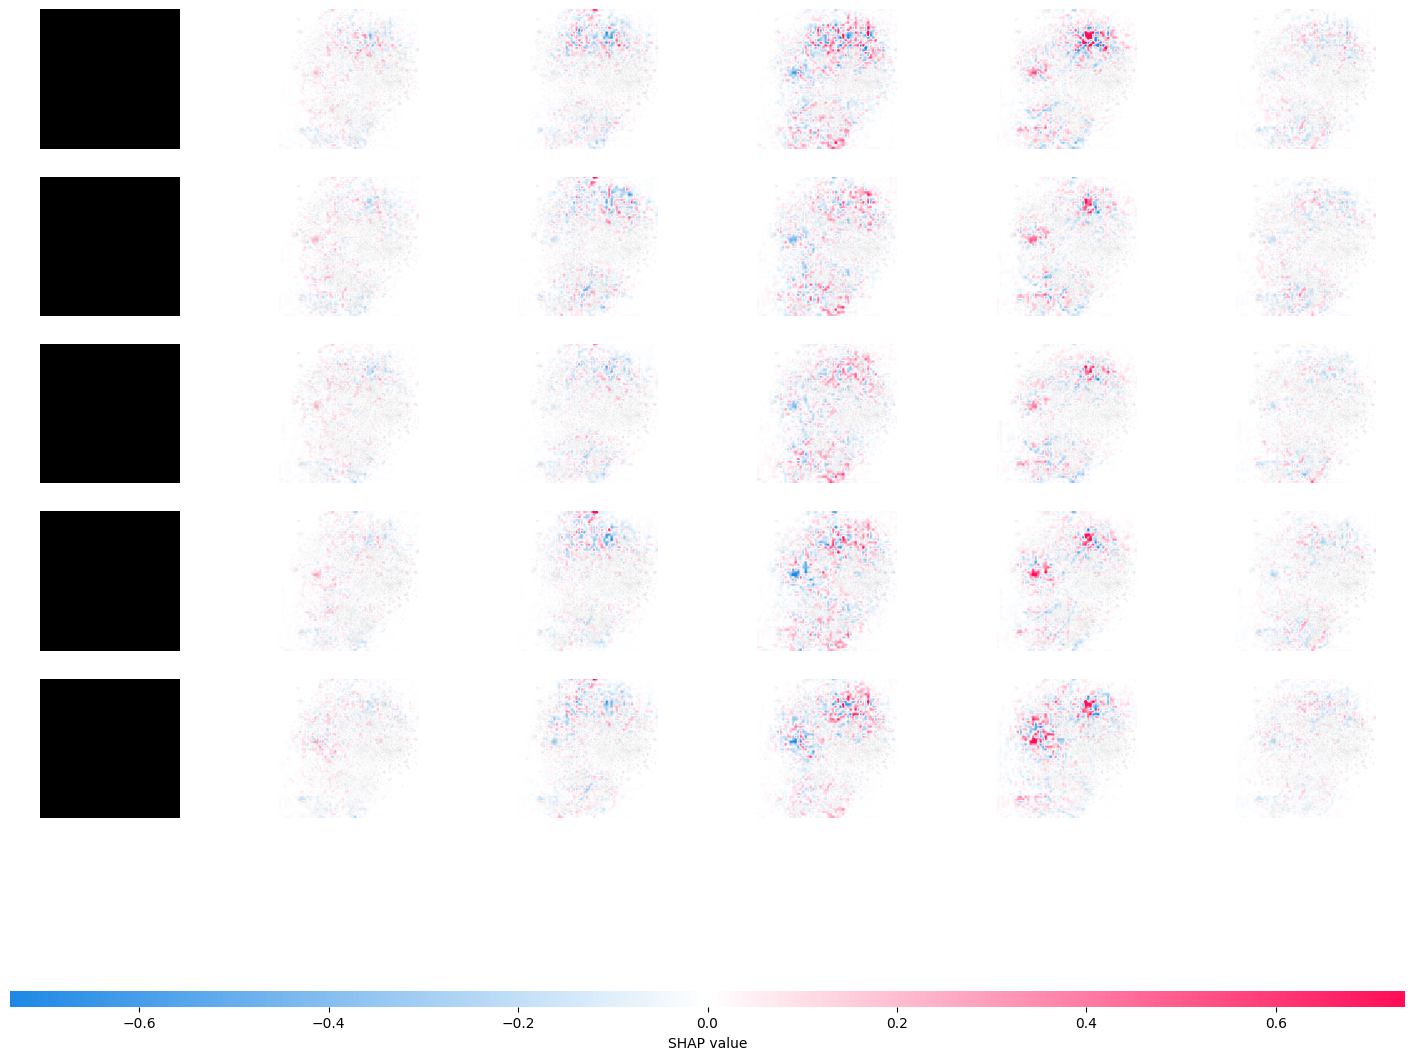

In [ ]:
# Convert SHAP values and test images to a suitable format for visualization
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

# Visualize the SHAP values
shap.image_plot(shap_numpy, -test_numpy)

## NNs

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/Breast_cancer_subtype_data_zscore_normal.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


In [ ]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [ ]:
# Define the DCNNs' layers
def build_model(num_classes):
    model = Sequential([
          Dense(2500 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(1000 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(500 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(250 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(125 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(60 , activation= 'gelu', activity_regularizer=tf.keras.regularizers.l2(1e-10)),
          Dropout(0.5),
          Dense(5 , activation= 'softmax')
    ])
    return model

### Cross Validation

In [ ]:
random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

acc_per_fold = []
loss_per_fold = []
fold_no = 1
batch_size = 16
epoch_num = 100

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=38, stratify=y)

num_classes = len(np.unique(y))

for train_index, test_index in kf.split(X_train_temp):

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    print(f'Training for fold {fold_no} ...')

    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])

    history = model.fit(X_train, y_train,
                        epochs=epoch_num,
                        batch_size=batch_size,
                        validation_split = 0.1,
                        callbacks=[early_stopping],
                        verbose = 0)

    y_pred = model.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Calculate metrics
    print(f"Accuracy: {accuracy_score(y_val, y_pred_class)}")
    accuracies.append(accuracy_score(y_val, y_pred_class))
    f1_scores.append(f1_score(y_val, y_pred_class, average='weighted', zero_division=0))
    precisions.append(precision_score(y_val, y_pred_class, average='weighted', zero_division=0))
    recalls.append(recall_score(y_val, y_pred_class, average='weighted', zero_division=0))

    fold_no = fold_no + 1

Training for fold 1 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.7261904761904762
Training for fold 2 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.8571428571428571
Training for fold 3 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.7619047619047619
Training for fold 4 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.8192771084337349
Training for fold 5 ...


3/3 [==============================] - 0s 3ms/step
Accuracy: 0.7951807228915663
Training for fold 6 ...


3/3 [==============================] - 0s 3ms/step
Accuracy: 0.7710843373493976
Training for fold 7 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.6987951807228916
Training for fold 8 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.8313253012048193
Training for fold 9 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.6385542168674698
Training for fold 10 ...
3/3 [==============================] - 0s 3ms/step
Accuracy: 0.8192771084337349


In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.7718732071141711
Average F1 Score: 0.7247266060443157
Average Precision: 0.7163769337828106
Average Recall: 0.7718732071141711


### test accuracy


In [ ]:
start_time = time.time()
batch_size = 16
epoch_num = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:, var_filter])
X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])

history = model.fit(X_train, y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 1)

y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

end_time = time.time()
Eplapse_time = end_time - start_time
print(f"The elapse time is:{Eplapse_time} seconds")

Epoch 1/100


UnimplementedError: Graph execution error:

Detected at node Cast_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-59-2df32c0cc6ae>", line 31, in <cell line: 31>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 708, in update_state

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to float is not supported
	 [[{{node Cast_1}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27339]

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate recall
recall = recall_score(y_test, y_pred_class, average='weighted')
print(f'Recall: {recall * 100:.2f}%')

# Calculate precision
precision = precision_score(y_test, y_pred_class, average='weighted')
print(f'Precision: {precision * 100:.2f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred_class, average='weighted')
print(f'F1 Score: {f1 * 100:.2f}%')

report = classification_report(y_test,
                               y_pred_class,
                               target_names=['0', '1', '2', '3', '4'])
print(report)

Accuracy: 85.28%
Recall: 85.28%
Precision: 84.91%
F1 Score: 84.81%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.75      0.75      0.75        16
           2       0.87      0.90      0.89       100
           3       0.78      0.80      0.79        40
           4       0.67      0.29      0.40         7

    accuracy                           0.85       197
   macro avg       0.80      0.74      0.75       197
weighted avg       0.85      0.85      0.85       197



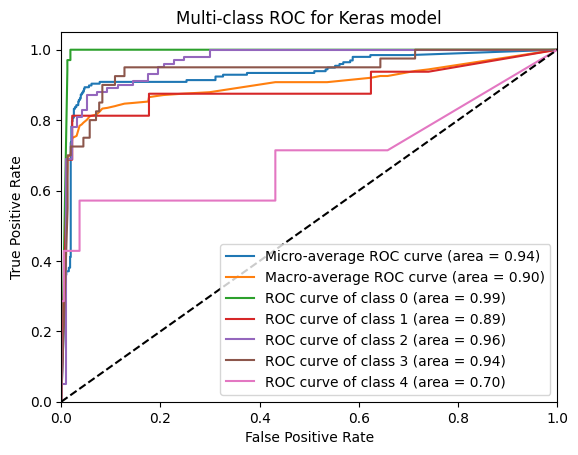

In [ ]:
# Assuming you have trained your model and have the predictions y_pred

# Binarize the output for AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for Keras model')
plt.legend(loc="lower right")
plt.show()


### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is: {ratio}:")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=38, stratify=y)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  model = build_model(num_classes)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Define the early stopping callback
  early_stopping = EarlyStopping(
      monitor='val_loss',  # Monitor the validation loss
      patience=20,         # Number of epochs with no improvement after which training will be stopped
      restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
  )

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])
  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])

  history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=batch_size,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

  y_pred = model.predict(X_test)
  y_pred_class = np.argmax(y_pred, axis=1)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred_class)
  print(f'Accuracy: {accuracy * 100:.2f}%')

  # Calculate recall
  recall = recall_score(y_test, y_pred_class, average='weighted')
  print(f'Recall: {recall * 100:.2f}%')

  # Calculate precision
  precision = precision_score(y_test, y_pred_class, average='weighted')
  print(f'Precision: {precision * 100:.2f}%')

  # Calculate F1 score
  f1 = f1_score(y_test, y_pred_class, average='weighted')
  print(f'F1 Score: {f1 * 100:.2f}%')

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")


  # Binarize the labels for AUC calculation
  y_test_binarized = label_binarize(y_test, classes=np.unique(y))

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy)
  avg_f1.append(f1)
  avg_pre.append(precision)
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is: 0.1:
4/4 [==============================] - 0s 3ms/step
Accuracy: 78.79%
Recall: 78.79%
Precision: 83.89%
F1 Score: 79.44%
Total elapsed time: 52.617385387420654 seconds
AUC for split ratio 0.1: 0.9146037287021332
The split ratio is: 0.15:
5/5 [==============================] - 0s 3ms/step
Accuracy: 87.16%
Recall: 87.16%
Precision: 87.77%
F1 Score: 87.17%
Total elapsed time: 57.17596197128296 seconds
AUC for split ratio 0.15: 0.9262222881724081
The split ratio is: 0.2:
7/7 [==============================] - 0s 2ms/step
Accuracy: 82.23%
Recall: 82.23%
Precision: 82.26%
F1 Score: 82.23%
Total elapsed time: 45.45376753807068 seconds
AUC for split ratio 0.2: 0.9253338137026959
The split ratio is: 0.25:
8/8 [==============================] - 0s 3ms/step
Accuracy: 61.79%
Recall: 61.79%
Precision: 79.01%
F1 Score: 61.45%
Total elapsed time: 41.396355628967285 seconds
AUC for split ratio 0.25: 0.9129603903689855
The split ratio is: 0.3:
10/10 [==============================

In [ ]:
# Print the average metrics
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Accuracy: 0.7867239837655309
Average F1 Score: 0.7878759031977177
Average Precision: 0.836421725915859
Average Computing time: 50.12142963409424
Average AUC: 0.919576248297221


### Train 5 times for each ratio


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
Training seed 8:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
Training seed 19:


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Training seed 66:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Training seed 38:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Avreage accuracy: 0.7737373737373737
Avreage F1: 0.7358683508338546
Avreage precision: 0.7119168758180731
Avreage auc: 0.9014891204063161
Avreage time: 39.70842666625977
The split ratio is: 0.15:
Training seed 3:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Training seed 8:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Training seed 19:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Training seed 66:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Training seed 38:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Avreage accuracy: 0.7527027027027027
Avreage F1: 0.7062474982747368
Avreage precision: 0.6976954914171241
Avreage auc: 0.8824803473430569
Avreage time: 37.29095044136047
The split ratio is: 0.2:
Training seed 3:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Training seed 8:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training seed 19:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training seed 6

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.4,0.5,0.6,0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.4:
Training seed 3:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Training seed 8:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training seed 19:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training seed 66:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training seed 38:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Avreage accuracy: 0.7150127226463104
Avreage F1: 0.6540133195429754
Avreage precision: 0.6428452775655973
Avreage auc: 0.8332025988547812
Avreage time: 28.604638195037843
The split ratio is: 0.5:
Training seed 3:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Training seed 8:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training seed 19:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training seed 66:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training seed 38:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Avreage accuracy: 0.7258655804480652
Avreage F1: 0.6868944755273959
Avreage precision: 0.6790103336946027
Avreage auc: 0.8345914273767099
Avreage time: 30.50339789390564
The split ratio is: 0.6:
Training

### Feature selection

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [ ]:
batch_size = 16
epoch_num = 100

# X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X, y_enc)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)
# Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])
# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

history = model.fit(X_train, y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 1)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.2132 - loss: 63.9712 - val_accuracy: 0.0080 - val_loss: 1.7988
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2024 - loss: 4.9502 - val_accuracy: 0.0240 - val_loss: 1.5408
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2483 - loss: 2.2552 - val_accuracy: 0.0200 - val_loss: 1.5445
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2170 - loss: 2.0510 - val_accuracy: 0.0440 - val_loss: 1.5504
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2226 - loss: 1.9107 - val_accuracy: 0.0000e+00 - val_loss: 1.6819
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2344 - loss: 1.8259 - val_accuracy: 0.0000e+00 - val_loss: 1.7284
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3160 - loss: 1.6031 - val_accuracy: 0.0000e+00 - val_loss: 1.8384
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3203 - loss: 1.

In [ ]:
import tensorflow as tf

def integrated_gradients(model, baseline, inputs, steps=50):
    # Generate the interpolated inputs between baseline and input
    interpolated_inputs = [baseline + (step / steps) * (inputs - baseline) for step in range(steps + 1)]
    interpolated_inputs = tf.convert_to_tensor(interpolated_inputs)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Set a baseline (can be a zero vector)
baseline = np.zeros(X_train.shape[1])

# Compute Integrated Gradients for a sample
ig = integrated_gradients(model, baseline, X_train[:100])
ig_sum = tf.reduce_mean(ig, axis=0)
top_20_indices = np.argsort(ig_sum)[-20:]
top_20_genes = retained_features[top_20_indices]


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  ...
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]]

 [[ 2.125000e-02  2.810800e-02 -5.263600e-02 ... -1.345000e-02
    5.602000e-03  2.886000e-03]
  [ 6.484000e-03  3.776600e-02 -2.350000e-02 ...  1.080600e-02
   -2.416600e-02 -6.252000e-02]
  [ 1.229000e-02  1.734200e-02  5.656000e-02 ...  1.035600e-02
   -5.169600e-02 -4.870000e-02]
  ...
  [ 2.883600e-02  2.060600e-02  1.247140e-01 ... -4.752400e-02
    1.825400e-02 -3.067000e-02]
  [-4.054200e-02 -1.642600e-02  1.361000e-02 ... -7.166000e-03
   -4.873400e-02 -2.891200e-02]
  [ 1.215600e-02  2.313400e-02 -2.073600e-02 ... -4.874800e-02
   -2.812200e-02 -4.900000e-03]]

 [[ 4.250000e-02  5.621600e-02 -1.052720e-01 ... -2.690000e-02
    1.120400e-02  5.772000e-03]
  [ 1.296800e-02  7.553200e-02 -4.700000e-02 ...  2.161200e-02
   -4.833200e-02 -1.250400e-01]
  [ 2.458000e-02  3.468400e-02  1.131200e-01 ...  2.071200e-02
   -1.033920e-01 -9.740000e-02]
  ...
  [ 5.767200e-02  4.121200e-02  2.494280e-01 ... -9.504800e-02
    3.650800e-02 -6.134000e-02]
  [-8.108400e-02 -3.285200e-02  2.722000e-02 ... -1.433200e-02
   -9.746800e-02 -5.782400e-02]
  [ 2.431200e-02  4.626800e-02 -4.147200e-02 ... -9.749600e-02
   -5.624400e-02 -9.800000e-03]]

 ...

 [[ 1.020000e+00  1.349184e+00 -2.526528e+00 ... -6.456000e-01
    2.688960e-01  1.385280e-01]
  [ 3.112320e-01  1.812768e+00 -1.128000e+00 ...  5.186880e-01
   -1.159968e+00 -3.000960e+00]
  [ 5.899200e-01  8.324160e-01  2.714880e+00 ...  4.970880e-01
   -2.481408e+00 -2.337600e+00]
  ...
  [ 1.384128e+00  9.890880e-01  5.986272e+00 ... -2.281152e+00
    8.761920e-01 -1.472160e+00]
  [-1.946016e+00 -7.884480e-01  6.532800e-01 ... -3.439680e-01
   -2.339232e+00 -1.387776e+00]
  [ 5.834880e-01  1.110432e+00 -9.953280e-01 ... -2.339904e+00
   -1.349856e+00 -2.352000e-01]]

 [[ 1.041250e+00  1.377292e+00 -2.579164e+00 ... -6.590500e-01
    2.744980e-01  1.414140e-01]
  [ 3.177160e-01  1.850534e+00 -1.151500e+00 ...  5.294940e-01
   -1.184134e+00 -3.063480e+00]
  [ 6.022100e-01  8.497580e-01  2.771440e+00 ...  5.074440e-01
   -2.533104e+00 -2.386300e+00]
  ...
  [ 1.412964e+00  1.009694e+00  6.110986e+00 ... -2.328676e+00
    8.944460e-01 -1.502830e+00]
  [-1.986558e+00 -8.048740e-01  6.668900e-01 ... -3.511340e-01
   -2.387966e+00 -1.416688e+00]
  [ 5.956440e-01  1.133566e+00 -1.016064e+00 ... -2.388652e+00
   -1.377978e+00 -2.401000e-01]]

 [[ 1.062500e+00  1.405400e+00 -2.631800e+00 ... -6.725000e-01
    2.801000e-01  1.443000e-01]
  [ 3.242000e-01  1.888300e+00 -1.175000e+00 ...  5.403000e-01
   -1.208300e+00 -3.126000e+00]
  [ 6.145000e-01  8.671000e-01  2.828000e+00 ...  5.178000e-01
   -2.584800e+00 -2.435000e+00]
  ...
  [ 1.441800e+00  1.030300e+00  6.235700e+00 ... -2.376200e+00
    9.127000e-01 -1.533500e+00]
  [-2.027100e+00 -8.213000e-01  6.805000e-01 ... -3.583000e-01
   -2.436700e+00 -1.445600e+00]
  [ 6.078000e-01  1.156700e+00 -1.036800e+00 ... -2.437400e+00
   -1.406100e+00 -2.450000e-01]]]. Expected shape (None, 19737), but input has incompatible shape (51, 100, 19737)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(51, 100, 19737), dtype=float32)
  • training=None
  • mask=None

In [ ]:
import tensorflow as tf
import numpy as np

def integrated_gradients(model, baseline, inputs, steps=50):
    # Ensure inputs are correctly shaped (batch_size, num_features)
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    # Generate the interpolated inputs between baseline and input
    interpolated_inputs = [(baseline + (step / steps) * (inputs - baseline)) for step in range(steps + 1)]

    # Stack interpolated inputs along the batch dimension
    interpolated_inputs = tf.stack(interpolated_inputs)

    # Reshape to have (steps+1, batch_size, num_features) instead of (steps+1, batch_size, batch_size, num_features)
    interpolated_inputs = tf.reshape(interpolated_inputs, ((steps + 1) * inputs.shape[0], inputs.shape[1]))

    # Record the gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)

    # Reshape gradients back to (steps+1, batch_size, num_features)
    gradients = tf.reshape(gradients, (steps + 1, inputs.shape[0], inputs.shape[1]))

    # Average the gradients across all steps
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    # Multiply by the input difference to get integrated gradients
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Step 2: Define a baseline (a zero vector, representing absence of any feature)
baseline = np.zeros(X_train.shape[1])

# Step 3: Compute Integrated Gradients for a subset of samples
ig = integrated_gradients(model, baseline, X_train[:100], steps=50)

# Step 4: Aggregate the Integrated Gradients across samples and identify top features
ig_sum = tf.reduce_mean(ig, axis=0)

# Step 5: Get indices of the top 20 features with highest importance scores
top_20_indices = np.argsort(ig_sum)[-20:]

# Step 6: Extract the feature names from retained features
top_20_features = retained_features[top_20_indices]

# Step 7: Output the top 20 important features
print("Top 20 features:", top_20_features)


Top 20 features: ['728461' '677803' '1538' '285375' '8354' '256144' '23436' '219436'
 '391003' '79501' '282617' '10281' '390323' '9356' '5407' '390321'
 '219952' '390162' '677836' '81697']


In [ ]:
print(top_20_genes)

NameError: name 'top_20_genes' is not defined

## LightGBM

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/BRCA_TCGA.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


In [ ]:
Breast_cancer_no_na

,0,1,2,3,4,5,6,7,8,9,...,20522,20523,20524,20525,20526,20527,20528,20529,20530,Subtype
0,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,0.0000,0.0,...,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460,BRCA_LumA
1,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,0.5438,0.0,...,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743,BRCA_Her2
2,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,0.0000,0.0,...,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519,BRCA_LumB
3,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,0.0000,0.0,...,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869,BRCA_LumA
4,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,0.0000,0.0,...,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702,BRCA_LumA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.0000,0.0000,3.2580,42.2643,1877.420,0.0,704.541,4.0725,0.0000,0.0,...,180.819,24.4349,243.535,772.959,98.5543,315.211,10937.10,800.652,443.087,BRCA_LumA
1078,0.0000,14.3858,21.4409,137.7760,652.756,0.0,427.165,2.7559,0.0000,0.0,...,457.087,70.8661,643.701,1266.540,21.2598,688.189,5118.11,1933.860,670.079,BRCA_LumA
1079,0.0000,22.3240,27.2744,64.1427,722.721,0.0,376.476,0.4724,0.0000,0.0,...,694.379,48.6538,341.521,1375.530,164.3840,746.812,5477.56,1437.410,953.708,BRCA_LumA
1080,0.0000,2.2638,7.2933,85.0461,1140.280,0.0,252.068,0.5973,0.0000,0.0,...,258.639,32.2552,248.484,796.225,51.9667,505.928,6675.63,754.413,750.829,BRCA_LumA


### Cross validation

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
# tell LightGBM to use the NVIDIA OpenCL installable client driver (ICD)
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
random_state = 38
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
accuracies_gbm = []
f1_scores_gbm = []
precisions_gbm = []
recalls_gbm = []
confusion_matrices_gbm = []
kappas_gbm = []
hamming_distances_gbm = []

for train_index, test_index in kf.split(X_train_temp):
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])


    train_data = lgb.Dataset(X_train, label=y_train)

    # Define the parameters for LightGBM
    params = {
        #'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': random_state
    }
    # Train the model
    num_round = 10
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_val)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics
    accuracies_gbm.append(accuracy_score(y_val, y_pred_class))
    f1_scores_gbm.append(f1_score(y_val, y_pred_class, average='weighted'))
    precisions_gbm.append(precision_score(y_val, y_pred_class, average='weighted'))
    recalls_gbm.append(recall_score(y_val, y_pred_class, average='weighted'))

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f'Average Accuracy: {np.mean(accuracies_gbm)}')
print(f'Average F1 Score: {np.mean(f1_scores_gbm)}')
print(f'Average Precision: {np.mean(precisions_gbm)}')
print(f'Average Recall: {np.mean(recalls_gbm)}')

Average Accuracy: 0.7971744119334481
Average F1 Score: 0.7650470285604987
Average Precision: 0.793705752318363
Average Recall: 0.7971744119334481


### Test accuracy

In [ ]:
start_time = time.time()
random_state = 38
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X_train, y_train)

#var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


train_data = lgb.Dataset(X_train, label=y_train)

# Define the parameters for LightGBM
params = {
    #'device_type': 'gpu',
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': random_state
}
# Train the model
num_round = 10
lgbm_model = lgb.train(params, train_data, num_round)
# Predict on the test set
y_pred = lgbm_model.predict(X_test)
# Convert the probabilities into class predictions
y_pred_class = np.argmax(y_pred, axis=1)
# Calculate metrics

print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
The test accuracy was 0.863
F1 Score: 0.8605189314786608
Precision: 0.8605189314786608
Elapsed time: 37.60211491584778 seconds


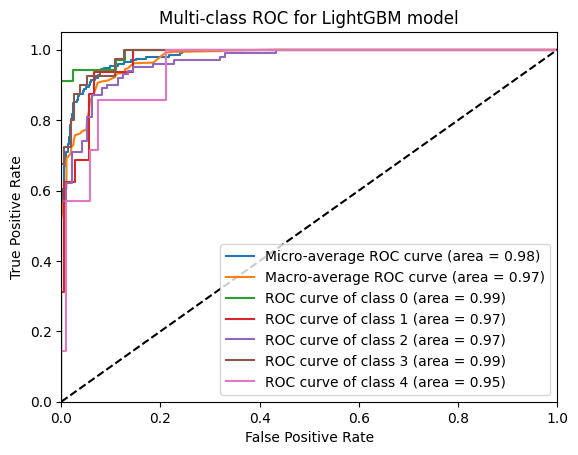

In [ ]:
# Assuming you have already split your data, standardized it, and trained your model

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for LightGBM model')
plt.legend(loc="lower right")
plt.show()


### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is {ratio}:")

  random_state = 38
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=random_state, stratify=y)

  # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  # X_train, y_train = smote.fit_resample(X_train, y_train)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:, var_filter])

  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])


  train_data = lgb.Dataset(X_train, label=y_train)

  # Define the parameters for LightGBM
  params = {
      #'device_type': 'gpu',
      'objective': 'multiclass',
      'num_class': len(np.unique(y)),
      'metric': 'multi_logloss',
      'is_unbalance': 'true',
      'boosting_type': 'gbdt',
      'num_leaves': 50,
      'learning_rate': 0.05,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'verbose': 0,
      'random_state': random_state
  }
  # Train the model
  num_round = 10
  lgbm_model = lgb.train(params, train_data, num_round)
  # Predict on the test set
  y_pred = lgbm_model.predict(X_test)
  # Convert the probabilities into class predictions
  y_pred_class = np.argmax(y_pred, axis=1)
  # Calculate metrics

  print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
  print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")


  # Binarize the labels for AUC calculation
  y_test_binarized = label_binarize(y_test, classes=np.unique(y))

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy_score(y_pred_class, y_test))
  avg_f1.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)


The split ratio is 0.1:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
The test accuracy was 0.848
F1 Score: 0.8496071829405162
Precision: 0.8560606060606061
Total elapsed time: 39.25266790390015 seconds
AUC for split ratio 0.1: 0.9595515919287058
The split ratio is 0.15:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
The test accuracy was 0.

KeyboardInterrupt: 

In [ ]:
# Print the average metrics
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Computing time: 42.210358190536496
Average Accuracy: 0.8623192315716389
Average F1 Score: 0.8621160909936305
Average Precision: 0.8643266223414138
Average AUC: 0.9669414080929645


### Training 5 times for each ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = lgb.Dataset(X_train, label=y_train)
    # Define the parameters for LightGBM
    params = {
        #'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 38
    }
    # Train the model
    num_round = 5
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics

    #print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
    #print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time_1} seconds")

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))


    avg_acc_s.append(accuracy_score(y_pred_class, y_test))
    avg_f1_s.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro'))
    avg_aupr_s.append(average_precision_score(y_test_binarized, y_pred, average="weighted"))

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))
  avg_aupr.append(np.mean(avg_aupr_s))


The split ratio is: 0.1:
Training seed 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### Other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.4, 0.5, 0.6, 0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = lgb.Dataset(X_train, label=y_train)
    # Define the parameters for LightGBM
    params = {
        #'device_type': 'gpu',
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 38
    }
    # Train the model
    num_round = 5
    lgbm_model = lgb.train(params, train_data, num_round)
    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)
    # Convert the probabilities into class predictions
    y_pred_class = np.argmax(y_pred, axis=1)
    # Calculate metrics

    #print(f"The test accuracy was {accuracy_score(y_pred_class, y_test):.3f}")
    #print(f"F1 Score: {f1_score(y_pred_class, y_test, average='weighted', zero_division=0)}")
    #print(f"Precision: {precision_score(y_pred_class, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time_1} seconds")

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))


    avg_acc_s.append(accuracy_score(y_pred_class, y_test))
    avg_f1_s.append(f1_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred_class, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro'))
    avg_aupr_s.append(average_precision_score(y_test_binarized, y_pred, average="weighted"))

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage aupr: {np.mean(avg_aupr_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))
  avg_aupr.append(np.mean(avg_aupr_s))


The split ratio is: 0.4:
Training seed 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### Feature selection

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
#X = Breast_cancer_no_na.drop(['Subtype', '100133144'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [ ]:
X

array([[ 1.0625,  1.4054, -2.6318, ..., -0.6725,  0.2801,  0.1443],
       [ 0.3242,  1.8883, -1.175 , ...,  0.5403, -1.2083, -3.126 ],
       [ 0.6145,  0.8671,  2.828 , ...,  0.5178, -2.5848, -2.435 ],
       ...,
       [ 1.477 ,  2.639 , -1.5958, ...,  0.527 , -0.8543, -0.5108],
       [-1.2857,  0.5014, -0.1787, ...,  1.0593, -3.4997, -1.2451],
       [-0.0463,  2.478 ,  3.245 , ..., -0.754 , -4.6896, -2.7345]])

In [ ]:
start_time = time.time()
random_state = 38
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X, y)

# #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# retained_features = np.array(genes)#[var_filter]
# # Standardization
# scaler = StandardScaler().fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


train_data = lgb.Dataset(X_train, label=y_train)

# Define the parameters for LightGBM
params = {
    #'device_type': 'gpu',
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': random_state
}
# Train the model
num_round = 5
lgbm_model = lgb.train(params, train_data, num_round)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
retained_features = np.array(genes)
# Get feature importances from the LightGBM model
importances = lgbm_model.feature_importance(importance_type='split')

# Sort the feature indices based on importance
sorted_indices = np.argsort(importances)[::-1]

# Select the top 20 features
top_20_indices = sorted_indices[:21]

# Retrieve the gene names for the top 20 features
top_20_genes = retained_features[top_20_indices]

print(top_20_genes)

['2099' '100133144' '81706' '29089' '8190' '55165' '2064' '79083' '10200'
 '84152' '3938' '12' '10887' '284434' '3852' '6790' '2894' '3872' '728264'
 '4257' '80019']


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/BRCA_TCGA.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


### Cross validation

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=38, stratify=y_enc)
print(X_train_temp.shape)
print(X_test.shape)

random_state = 38
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store metrics for each fold
fold_no = 1
accuracies = []
f1_scores = []
precisions = []
recalls = []
confusion_matrices = []
kappas = []
hamming_distances = []


for train_index, test_index in kf.split(X_train_temp):
    print(f"Training for fold{fold_no}...")
    X_train, X_val = X_train_temp[train_index], X_train_temp[test_index]
    y_train, y_val = y_train_temp[train_index], y_train_temp[test_index]

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train[:, var_filter])

    X_train = scaler.transform(X_train[:, var_filter])
    X_val = scaler.transform(X_val[:, var_filter])

    clf= DecisionTreeClassifier(random_state = 38)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_val)

     # Calculate metrics
    print(f"Accuracy: {accuracy_score(y_pred, y_val) * 100 :.3f}")
    accuracies.append(accuracy_score(y_pred, y_val))
    f1_scores.append(f1_score(y_pred, y_val, average='weighted', zero_division=0))
    precisions.append(precision_score(y_pred, y_val, average='weighted', zero_division=0))
    recalls.append(recall_score(y_pred, y_val, average='weighted', zero_division=0))

    fold_no += 1

(833, 19737)
(148, 19737)
Training for fold1...
Accuracy: 78.571
Training for fold2...
Accuracy: 77.381
Training for fold3...
Accuracy: 83.333
Training for fold4...
Accuracy: 78.313
Training for fold5...
Accuracy: 74.699
Training for fold6...
Accuracy: 79.518
Training for fold7...
Accuracy: 79.518
Training for fold8...
Accuracy: 75.904
Training for fold9...
Accuracy: 71.084
Training for fold10...
Accuracy: 83.133


In [ ]:
# After cross-validation, calculate the average of the metrics
avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1_score}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')

Average Accuracy: 0.7814543889845095
Average F1 Score: 0.7832450955145365
Average Precision: 0.793316803269783
Average Recall: 0.7814543889845095


### Test Accuracy

In [ ]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
# X_train, y_train = smote.fit_resample(X_train, y_train)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train[:,var_filter])

X_train = scaler.transform(X_train[:, var_filter])
X_test = scaler.transform(X_test[:, var_filter])

clf= DecisionTreeClassifier(random_state = 38)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

  # Calculate metrics
print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time_1 = end_time - start_time
print(f"Elapsed time: {elapsed_time_1} seconds")

KeyboardInterrupt: 

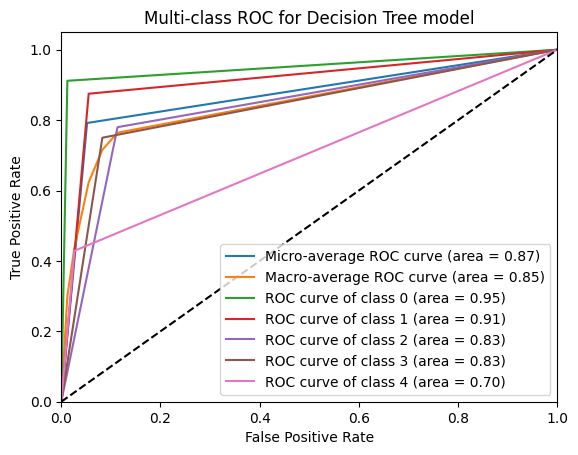

In [ ]:
# Your existing code for training the Decision Tree Classifier

# Predict probability scores
y_prob = clf.predict_proba(X_test)

# Binarize the output for AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for Decision Tree model')
plt.legend(loc="lower right")
plt.show()

### Different train test split ratio

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
for ratio in split_ratio:
  # Start timing
  start_time = time.time()
  print(f"The split ratio is {ratio}:")

  X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=ratio, random_state=38, stratify=y_enc)

  smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

  # Standardization
  scaler = StandardScaler().fit(X_train[:,var_filter])

  X_train = scaler.transform(X_train[:, var_filter])
  X_test = scaler.transform(X_test[:, var_filter])

  clf= DecisionTreeClassifier(random_state = 38)
  clf.fit(X_train,y_train)
  y_pred= clf.predict(X_test)

    # Calculate metrics
  print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
  print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
  print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

  # End timing
  end_time = time.time()
  # Calculate and print the elapsed time
  elapsed_time = end_time - start_time
  print(f"Total elapsed time: {elapsed_time} seconds")

  # Get the probability estimates
  y_pred_proba = clf.predict_proba(X_test)

  # Binarize the labels for AUC calculation
  y_test_binarized = label_binarize(y_test, classes=np.unique(y_enc))

  # Calculate AUC for each class and average
  auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
  print(f"AUC for split ratio {ratio}: {auc_score}")

  avg_acc.append(accuracy_score(y_pred, y_test))
  avg_f1.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
  avg_pre.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
  avg_time.append(elapsed_time)
  avg_auc.append(auc_score)

The split ratio is 0.1:
Accuracy: 78.788
F1 Score: 0.7824833952493528
Precision: 0.7878787878787878
Total elapsed time: 28.257932424545288 seconds
AUC for split ratio 0.1: 0.8482426958418877
The split ratio is 0.15:
Accuracy: 83.108
F1 Score: 0.8314095397321037
Precision: 0.8363270963270963
Total elapsed time: 27.493754386901855 seconds
AUC for split ratio 0.15: 0.8587382351479068
The split ratio is 0.2:
Accuracy: 79.188
F1 Score: 0.7872181129063496
Precision: 0.7928264300644114
Total elapsed time: 25.273263692855835 seconds
AUC for split ratio 0.2: 0.8455297177918888
The split ratio is 0.25:
Accuracy: 77.642
F1 Score: 0.7740975660284937
Precision: 0.7785479476721678
Total elapsed time: 21.27346181869507 seconds
AUC for split ratio 0.25: 0.8445960678639889
The split ratio is 0.3:
Accuracy: 79.661
F1 Score: 0.7980306571923028
Precision: 0.8026314994410707
Total elapsed time: 21.29996633529663 seconds
AUC for split ratio 0.3: 0.8328895904485449


In [ ]:
# Print the average metrics
print(f'Average Computing time: {np.mean(avg_time)}')
print(f'Average Accuracy: {np.mean(avg_acc)}')
print(f'Average F1 Score: {np.mean(avg_f1)}')
print(f'Average Precision: {np.mean(avg_pre)}')
print(f'Average AUC: {np.mean(avg_auc)}')

Average Computing time: 24.719675731658935
Average Accuracy: 0.7967741950535738
Average F1 Score: 0.7946478542217206
Average Precision: 0.7996423522767069
Average AUC: 0.8459992614188433


### Training 5 times for each ratio

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

# smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

# Standardization
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'criterion': ['gini'],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=38)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit it to the data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []
avg_aupr = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf= DecisionTreeClassifier(random_state = 38,
                                criterion = 'gini',
                                max_depth =  20,
                                max_features = 'sqrt',
                                min_samples_leaf = 2,
                                min_samples_split = 2)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_test)

    # Calculate metrics
    # print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
    # print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
    # print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    # Get the probability estimates
    y_pred_proba = clf.predict_proba(X_test)

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_enc))
    aupr = average_precision_score(y_test_binarized, y_pred_proba, average="weighted")

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
    # print(f"AUC for split ratio {ratio}: {auc_score}")

    avg_acc_s.append(accuracy_score(y_pred, y_test))
    avg_f1_s.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage AUPR: {np.mean(avg_acc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.6808080808080809
Avreage F1: 0.6799136455208985
Avreage precision: 0.6900825906120024
Avreage auc: 0.7533952375073772
Avreage AUPR: 0.6808080808080809
Avreage time: 0.35880165100097655
The split ratio is: 0.15:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.6986486486486486
Avreage F1: 0.7013118012017989
Avreage precision: 0.713038115038115
Avreage auc: 0.7443133454177923
Avreage AUPR: 0.6986486486486486
Avreage time: 0.34233765602111815
The split ratio is: 0.2:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.7035532994923858
Avreage F1: 0.7066785333496177
Avreage precision: 0.7157832828562898
Avreage auc: 0.7447757983420031
Avreage AUPR: 0.7035532994923858
Avreage time: 0.34312710762023924
The split ratio is: 0.25:
Training seed 3:
Tra

### other ratios

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.3,0.4,0.5,0.6,0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  avg_aupr_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=ratio, random_state=seed, stratify=y_enc)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    #var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf= DecisionTreeClassifier(random_state = 38,
                                criterion = 'gini',
                                max_depth =  20,
                                max_features = 'sqrt',
                                min_samples_leaf = 2,
                                min_samples_split = 2)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_test)

    # Calculate metrics
    # print(f"Accuracy: {accuracy_score(y_pred, y_test) * 100 :.3f}")
    # print(f"F1 Score: {f1_score(y_pred, y_test, average='weighted', zero_division=0)}")
    # print(f"Precision: {precision_score(y_pred, y_test, average='weighted', zero_division=0)}")

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    #print(f"Total elapsed time: {elapsed_time} seconds")

    # Get the probability estimates
    y_pred_proba = clf.predict_proba(X_test)

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_enc))
    aupr = average_precision_score(y_test_binarized, y_pred_proba, average="weighted")

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
    # print(f"AUC for split ratio {ratio}: {auc_score}")

    avg_acc_s.append(accuracy_score(y_pred, y_test))
    avg_f1_s.append(f1_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_pred, y_test, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)
    avg_aupr_s.append(aupr)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage AUPR: {np.mean(avg_acc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.3:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.696271186440678
Avreage F1: 0.7049754172660393
Avreage precision: 0.7196483278464555
Avreage auc: 0.7315027099388182
Avreage AUPR: 0.696271186440678
Avreage time: 0.3060935974121094
The split ratio is: 0.4:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.689058524173028
Avreage F1: 0.6874315792595329
Avreage precision: 0.6894625375245449
Avreage auc: 0.7451414447600838
Avreage AUPR: 0.689058524173028
Avreage time: 0.2847123622894287
The split ratio is: 0.5:
Training seed 3:
Training seed 8:
Training seed 19:
Training seed 66:
Training seed 38:
Avreage accuracy: 0.6936863543788189
Avreage F1: 0.6980314274492574
Avreage precision: 0.7075814935859503
Avreage auc: 0.7372398208833906
Avreage AUPR: 0.6936863543788189
Avreage time: 0.26737141609191895
The split ratio is: 0.6:
Training seed 3:
Training s

### Feature selection

In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y_enc)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X, y_enc)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)
# # Standardization
# scaler = StandardScaler().fit(X_train[:,var_filter])

# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

clf= DecisionTreeClassifier(random_state = 38,
                            criterion = 'gini',
                            max_depth =  20,
                            max_features = 'sqrt',
                            min_samples_leaf = 2,
                            min_samples_split = 2)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       random_state=38)

In [ ]:
# Get feature importances from the decision tree model
importances = clf.feature_importances_

# Sort the importances and get the indices of the top 20
top_20_indices = np.argsort(importances)[-20:]

# Map these indices to the corresponding gene names in retained_features
top_20_genes = retained_features[top_20_indices]

top_20_genes


array(['369', '51816', '158798', '2118', '23198', '10257', '8520', '9727',
       '11126', '8552', '79772', '140701', '89782', '3800', '10238',
       '10055', '645', '284688', '5878', '6691'], dtype=object)

## DCGN


In [ ]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/Breast_cancer_subtype_data_zscore_normal.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1)
y = Breast_cancer_no_na['Subtype']

Breast_cancer_no_na.shape

X = X.to_numpy()
y = y.tolist()

le = LabelEncoder()
y = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y).size
print(le_mapping )

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Bidirectional, GRU, Flatten, Dropout

In [ ]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [ ]:
def build_model(num_classes):
    model = Sequential([
    Dense(1024,
          activation=gelu,
          kernel_regularizer=regularizers.l2()),

    Reshape((32, 32, 1)),

    Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Reshape((128, 64)),

    Bidirectional(
        GRU(64, return_sequences=True,
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))
    ),

    Reshape((128, 128, 1)),

    Conv2D(filters=64, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(128, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dense(64, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.6),
    Dense(32, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.7),

    Dense(5, activation= 'softmax')
    ])
    return model

### Without Smote

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Training seed 8:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Training seed 19:


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Training seed 66:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Training seed 38:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Avreage accuracy: 0.8383838383838385
Avreage F1: 0.8141289617482436
Avreage precision: 0.7970094287079553
Avreage auc: 0.9425152202858786
Avreage time: 55.26420135498047
The split ratio is: 0.15:
Training seed 3:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Training seed 8:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Training seed 19:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Training seed 66:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Training seed 38:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Avreage accuracy: 0.8297297297297297
Avreage F1: 0.808456108680301
Avreage precision: 0.7960256670015973
Avreage auc: 0.923089863083832
Avreage time: 48.27405886650085
The split ratio is: 0.2:
Training seed 3:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Training seed 8:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Training seed 19:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Training seed 66:

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.4,0.5,0.6,0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    # smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.4:
Training seed 3:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training seed 8:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 19:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 66:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training seed 38:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Avreage accuracy: 0.8096692111959287
Avreage F1: 0.7787571550092915
Avreage precision: 0.7678036847002265
Avreage auc: 0.9189163113938061
Avreage time: 37.667581987380984
The split ratio is: 0.5:
Training seed 3:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Training seed 8:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 19:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 66:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 38:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Avreage accuracy: 0.8183299389002038
Avreage F1: 0.798235252150906
Avreage precision: 0.7814584262891937
Avreage auc: 0.9345631698710719
Avreage time: 37.495252418518064
The split ratio is: 0.6:
Training

### With Smote


In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.1:
Training seed 3:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Training seed 8:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Training seed 19:


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Training seed 66:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Training seed 38:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Avreage accuracy: 0.8787878787878787
Avreage F1: 0.8745452322785188
Avreage precision: 0.8816937358258323
Avreage auc: 0.9631482193769472
Avreage time: 91.2181257724762
The split ratio is: 0.15:
Training seed 3:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Training seed 8:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Training seed 19:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Training seed 66:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Training seed 38:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Avreage accuracy: 0.8716216216216217
Avreage F1: 0.8717449148657035
Avreage precision: 0.8757382229590036
Avreage auc: 0.9634772136196631
Avreage time: 137.25674252510072
The split ratio is: 0.2:
Training seed 3:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Training seed 8:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Training seed 19:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Training seed 6

In [ ]:
avg_acc = []
avg_f1 = []
avg_pre = []
avg_time = []
avg_auc = []

split_ratio = [0.4,0.5,0.6,0.7]
seeds = [3, 8, 19, 66, 38]
for ratio in split_ratio:
  print(f"The split ratio is: {ratio}:")
  avg_acc_s = []
  avg_f1_s = []
  avg_pre_s = []
  avg_time_s = []
  avg_auc_s = []
  for seed in seeds:
    # Start timing
    start_time = time.time()

    print(f"Training seed {seed}:")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=seed, stratify=y)

    smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

    # Standardization
    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = build_model(num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=20,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split = 0.1,
                      callbacks=[early_stopping],
                      verbose = 0)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # End timing
    end_time = time.time()
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    # Binarize the labels for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))

    # Calculate AUC for each class and average
    auc_score = roc_auc_score(y_test_binarized, y_pred, multi_class='ovr', average='macro')

    avg_acc_s.append(accuracy_score(y_test, y_pred_class))
    avg_f1_s.append(f1_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_pre_s.append(precision_score(y_test, y_pred_class, average='weighted', zero_division=0))
    avg_time_s.append(elapsed_time)
    avg_auc_s.append(auc_score)

  print(f"Avreage accuracy: {np.mean(avg_acc_s)}")
  print(f"Avreage F1: {np.mean(avg_f1_s)}")
  print(f"Avreage precision: {np.mean(avg_pre_s)}")
  print(f"Avreage auc: {np.mean(avg_auc_s)}")
  print(f"Avreage time: {np.mean(avg_time_s)}")

  avg_acc.append(np.mean(avg_acc_s))
  avg_f1.append(np.mean(avg_f1_s))
  avg_pre.append(np.mean(avg_pre_s))
  avg_time.append(np.mean(avg_time_s))
  avg_auc.append(np.mean(avg_auc_s))

The split ratio is: 0.4:
Training seed 3:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 8:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Training seed 19:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Training seed 66:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training seed 38:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Avreage accuracy: 0.8641221374045802
Avreage F1: 0.8598360644274553
Avreage precision: 0.865736636278754
Avreage auc: 0.9533964905622293
Avreage time: 97.38207249641418
The split ratio is: 0.5:
Training seed 3:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 8:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 19:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training seed 66:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Training seed 38:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Avreage accuracy: 0.8594704684317719
Avreage F1: 0.8544662324569648
Avreage precision: 0.8611266200848217
Avreage auc: 0.9530168443904079
Avreage time: 82.60433855056763
The split ratio is: 0.6:
Training s

### Feature selection

In [3]:
Breast_cancer = pd.read_csv('/content/drive/MyDrive/Graduation_Project/data/Breast_cancer_data/breast_cancer_subtype_data_zscore_normal_withGeneID.csv')

Breast_cancer_no_na = Breast_cancer.dropna(subset = ['Subtype'])

Breast_cancer_no_na = Breast_cancer_no_na.dropna(axis = 1)
Breast_cancer_no_na.shape

X = Breast_cancer_no_na.drop(['Subtype'], axis=1).values
y = Breast_cancer_no_na['Subtype'].values
genes = Breast_cancer_no_na.iloc[:, :-1].columns.to_numpy()

le = LabelEncoder()
y_enc = le.fit_transform(y)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size
print(le_mapping )
print(Breast_cancer_no_na.shape)

{0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}
(981, 19738)


In [4]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Bidirectional, GRU, Flatten, Dropout

In [5]:
# Define gelu activation function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [6]:
def build_model(num_classes):
    model = Sequential([
    Dense(1024,
          activation=gelu,
          kernel_regularizer=regularizers.l2()),

    Reshape((32, 32, 1)),

    Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Reshape((128, 64)),

    Bidirectional(
        GRU(64, return_sequences=True,
            bias_regularizer=regularizers.l2(1e-4),
            activity_regularizer=regularizers.l2(1e-5))
    ),

    Reshape((128, 128, 1)),

    Conv2D(filters=64, kernel_size=3, padding='same', strides=2, activation=gelu),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(128, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dense(64, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.6),
    Dense(32, activation=gelu, kernel_regularizer=regularizers.l2()),
    Dropout(rate=0.7),

    Dense(5, activation= 'softmax')
    ])
    return model

In [7]:
batch_size = 16
epoch_num = 100

# X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=38, stratify=y)

smote = SMOTE(sampling_strategy= 'auto', k_neighbors=5, random_state=1207)
X_train, y_train = smote.fit_resample(X, y_enc)

model = build_model(num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')
retained_features = np.array(genes)
# Standardization
# scaler = StandardScaler().fit(X_train[:, var_filter])
# X_train = scaler.transform(X_train[:, var_filter])
# X_test = scaler.transform(X_test[:, var_filter])

history = model.fit(X_train, y_train,
                    epochs=epoch_num,
                    batch_size=batch_size,
                    validation_split = 0.1,
                    callbacks=[early_stopping],
                    verbose = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.2998 - loss: 6.1377 - val_accuracy: 0.0000e+00 - val_loss: 2.5325
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5903 - loss: 1.7628 - val_accuracy: 0.0280 - val_loss: 2.1185
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6955 - loss: 1.6727 - val_accuracy: 0.9880 - val_loss: 2.0814
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7346 - loss: 1.5221 - val_accuracy: 0.9800 - val_loss: 0.6387
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8369 - loss: 1.3311 - val_accuracy: 0.8920 - val_loss: 1.7294
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8846 - loss: 1.4362 - val_accuracy: 1.0000 - val_loss: 0.9854
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8944 - loss: 1.1217 - val_accuracy: 1.0000 - val_loss: 0.6270
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9123 - loss: 0.99

In [ ]:
pip install shap

In [ ]:
import shap
import numpy as np

# 1) Train the model
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# 2) Create a smaller background dataset
background_size = 100
X_background = X_train[np.random.choice(X_train.shape[0], background_size, replace=False)]

# 3) Use DeepExplainer or GradientExplainer
explainer = shap.DeepExplainer(model, X_background)

# 4) Pick a subset of test samples
n_test_samples = 200
X_test_subset = X_train[:n_test_samples]

# 5) Calculate SHAP values
shap_values = explainer.shap_values(X_test_subset)

# 6) Average across samples and classes
# If shap_values is a list for each class (multi-output), you can sum or average across them.
if isinstance(shap_values, list):  # multi-class scenario
    shap_values_total = np.mean(np.abs(np.stack(shap_values, axis=0)), axis=(0,1))
else:
    shap_values_total = np.mean(np.abs(shap_values), axis=0)

# 7) Sort features by importance
top_20_idx = np.argsort(shap_values_total)[-20:]
top_20_genes = [retained_features[i] for i in top_20_idx]

print("Top 20 genes by SHAP importance:")
for rank, gene in enumerate(top_20_genes[::-1], start=1):
    print(f"{rank}. {gene}")


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9679 - loss: 0.6301 - val_accuracy: 0.3166 - val_loss: 2.1098
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9461 - loss: 1.0539 - val_accuracy: 0.9719 - val_loss: 0.8241
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9180 - loss: 0.7287 - val_accuracy: 0.9719 - val_loss: 0.8287
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9612 - loss: 0.5295 - val_accuracy: 0.9940 - val_loss: 0.9413
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9728 - loss: 0.5380 - val_accuracy: 0.9900 - val_loss: 0.8534
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9717 - loss: 0.6133 - val_accuracy: 0.2325 - val_loss: 1.8830
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9719 - loss: 0.8269 - val_accuracy: 0.8878 - val_loss: 1.1024
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9623 - loss: 0.5973 - val_accuracy: 0.9279 - v

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


StagingError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py", line 269, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_Pow


In [8]:
import tensorflow as tf
import numpy as np

def integrated_gradients(model, baseline, inputs, steps=50):
    # Ensure inputs are correctly shaped (batch_size, num_features)
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    # Generate the interpolated inputs between baseline and input
    interpolated_inputs = [(baseline + (step / steps) * (inputs - baseline)) for step in range(steps + 1)]

    # Stack interpolated inputs along the batch dimension
    interpolated_inputs = tf.stack(interpolated_inputs)

    # Reshape to have (steps+1, batch_size, num_features) instead of (steps+1, batch_size, batch_size, num_features)
    interpolated_inputs = tf.reshape(interpolated_inputs, ((steps + 1) * inputs.shape[0], inputs.shape[1]))

    # Record the gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)

    # Reshape gradients back to (steps+1, batch_size, num_features)
    gradients = tf.reshape(gradients, (steps + 1, inputs.shape[0], inputs.shape[1]))

    # Average the gradients across all steps
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    # Multiply by the input difference to get integrated gradients
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Step 2: Define a baseline (a zero vector, representing absence of any feature)
baseline = np.zeros(X_train.shape[1])

# Step 3: Compute Integrated Gradients for a subset of samples
with tf.device('/CPU:0'):
    ig = integrated_gradients(model, baseline, X_train[:100], steps=10)

# Step 4: Aggregate the Integrated Gradients across samples and identify top features
ig_sum = tf.reduce_mean(ig, axis=0)

# Step 5: Get indices of the top 20 features with highest importance scores
top_20_indices = np.argsort(ig_sum)[-20:]

# Step 6: Extract the feature names from retained features
top_20_features = retained_features[top_20_indices]

# Step 7: Output the top 20 important features
print("Top 20 features:", top_20_features)


Top 20 features: ['282617' '10281' '5407' '653275' '158511' '83755' '23614' '9356' '390323'
 '219952' '3651' '343070' '391003' '390321' '375318' '163778' '390162'
 '81697' '1068' '677836']
